# Simulating a Spiking Neural Network

@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

One of the most important approaches of studying brain dynamics is building a dynamic model and doing simulation. Generally, there are two ways to construct a dynamic model. The first one is called spiking models, which attempt to finely simulate the activity of each neuron in the target population. They are named spiking models because the simulation process records the precise timing of spiking of every neuron. The second is called rate models, which regard a population of neurons with similar properties as a single firing unit and examine the firing rate of this population. In this section, we will illustrate how to build and simulate a spiking neural network, e.i. SNN.

To begin with, the BrainPy package should be imported:

In [9]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

## Simulating an E-I balanced network

### Building an E-I balanced network

Firstly, let's try to build an E-I balanced network. It was proposed to interpret the irregular firing of neurons in the cortical area \[1\]. Since the structure of an E-I balanced network is relatively simple, it is a good practice that helps users to learn the basic paradigm of brain dynamic simulation in BrainPy. The structure of a E-I balanced network is as follows:

<center><img src="../_static/E_I_balance_network.png" width="400 px"></center>
<center>The stucture of an E-I Balanced Network</center>

A E-I balanced network is composed of two neuron groups and the synaptic connections between them. Specifically, they include:
1. a group of excitatory neurons, $\mathrm{E}$,
2. a group of inhibitory neurons, $\mathrm{I}$,
3. synaptic connections within the excitatory and inhibitory neuron groups, respectively, and 
4. the inter-connections between these two groups.

To construct the network, we need to define these components one by one. BrainPy provides plenty of handy built-in models for brain dynamic simulation. They are contained in ``brainpy.dyn``. Let's choose the simplest yet the most canonical neuron model, the Leaky Integrate-and-Fire (LIF) model, to build the excitatory and inhibitory neuron groups:

In [3]:
E = bp.dyn.LIF(3200, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5., method='exp_auto')
I = bp.dyn.LIF(800, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5., method='exp_auto')

E.V[:] = bp.math.random.randn(3200) * 2 - 60.
I.V[:] = bp.math.random.randn(800) * 2 - 60.

When defining the LIF neuron group, the parameters can be tuned according to users' need. The first parameter denotes the number of neurons. Here the ratio of excitatory and inhibitory neurons is set 4:1. ``V_rest`` denotes the resting potential, ``V_th`` denotes the firing threshold, ``V_reset`` denotes the reset value after firing, ``tau`` is the time constant, and ``tau_ref`` is the duration of the refractory period. ``method`` refers to the numerical integration method to be used in simulation. 

Then the synaptic connections between these two groups can be defined as follows:

In [4]:
E2E = bp.dyn.ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5., method='exp_auto')
E2I = bp.dyn.ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02), E=0., g_max=0.6, tau=5., method='exp_auto')
I2E = bp.dyn.ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10., method='exp_auto')
I2I = bp.dyn.ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02), E=-80., g_max=6.7, tau=10., method='exp_auto')

Here we use the Expnential synapse model (``ExpCOBA``) to simulate synaptic connections. Among the parameters of the model, the first two denotes the pre- and post-synaptic neuron groups, respectively. The third one refers to the connection types. In this example, we use ``bp.conn.FixedProb``, which connects the presynaptic neurons to postsynaptic neurons with a given probability (detailed information is available in [Synaptic Connection](../tutorial_toolbox/synaptic_connections.ipynb)). The following three parameters describes the dynamic properties of the synapse, and the last one is the numerical integration method as that in the LIF model.

After defining all the components, they can be combined to form a network:

In [5]:
net = bp.dyn.Network(E2E, E2I, I2E, I2I, E=E, I=I)

In the definition, neurons and synapses are given to the network. The excitatory and inhibitory neuron groups (`E` and `I`) are passed with a name, for they will be specifically operated in the simulation (here they will be given with input currents).

We have successfully constructed an E-I balanced network by using BrainPy's biult-in models. On the other hand, BrianPy also enables users to customize their own dynamic models such as neuron groups, synapses, and networks flexibly. In fact, ``brainpy.dyn.Network()`` is a simple example of customizing a network model. Please refer to [Dynamic Simulation](../tutorial_simulation/index.rst) for more information.

### Running a simulation

After build a SNN, we can use it for dynamic simulation. To run a simulation, we need first wrap the network model into a **runner**. Currently BrainPy provides ``DSRunner`` and ``ReportRunner`` in ``brainpy.dyn``, which will be expanded in the [Runners](../tutorial_simulation/runner.ipynb) tutorial. Here we use ``DSRunner`` as an example:

In [6]:
runner = bp.dyn.DSRunner(net,
                         monitors=['E.spike', 'I.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         dt=0.1)

To make dynamic simulation more applicable and powerful, users can [**monitor**](../tutorial_toolbox/monitors.ipynb) variable trajectories and give [**inputs**](../tutorial_toolbox/inputs.ipynb) to target neuron groups. Here we monitor the ``spike`` variable in the ``E`` and ``I`` LIF model, which refers to the spking status of the neuron group, and give a constant input to both neuron groups. The time interval of numerical integration ``dt`` (with the default value of 0.1) can also be specified.

After creating the runner, we can run a simulation by calling the runner:

In [7]:
runner(100)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.6904439926147461

where the calling function receives the simulation time (usually in milliseconds) as the input and returns the time (seconds) spent on simulation. BrainPy achieves an extraordinary simulation speed with the assistance of just-in-time (JIT) compilation. Please refer to [Just-In-Time Compilation](../tutorial_math/compilation.ipynb) for more details.

The simulation results are stored as NumPy arrays in the monitors, and can be visualized easily:

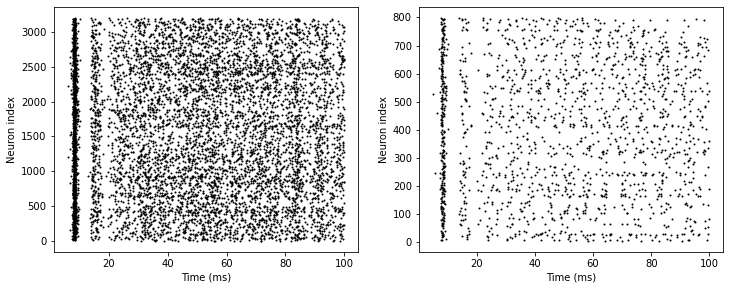

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4.5))

plt.subplot(121)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=False)
plt.subplot(122)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], show=True)

In the code above, ``brianpy.visualize`` contains some useful functions to visualize simulation results based on the ``matplotlib`` package. Since the simulation results are stored as NumPy arrays, users can directly use ``matplotlib`` for visualization.

## Simulating a decision-making network

### Building a decision-making network

After learning how to build a E-I balanced network, we can try to handle a more complex model. In 2002, Wang proposed a decision-making model that could choose between two conflict inputs by accumulating evidence over time \[2\]. 

The structure of a decision-making network is as follows. Similar to the E-I balanced network, the decision-making network contains an excitatory and an inhibitory neuron group, forming connections within each group and between each other. What is different is that there are two specific subpopulation of neurons, A and B, that receive conflict inputs from outside (other brain areas). After given the external inputs, if the activity of A prevail over B, it means the network chooses option A, and vice versa.

<center><img src="../_static/dmnet_diagram.png" width="400 px"></center>
<center>The stucture of an E-I Balanced Network</center>

To construct a decision-making network, we should build all neuron groups:

1. Two excicatory neuron groups with different selectivity, $\mathrm{A}$ and $\mathrm{B}$, and other excicatory neurons, $\mathrm{N}$;
2. An inhibitory neuron group, $\mathrm{I}$;
3. Neurons generating external inputs $\mathrm{I_A}$ and $\mathrm{I_B}$;
4. Neurons generating noise to all neuron groups, $\mathrm{noise_A}$, $\mathrm{noise_B}$, $\mathrm{noise_N}$, and $\mathrm{noise_I}$.

And the synapse connection between them:

1. Connection from excitatory neurons to others, $\mathrm{A2A}$, $\mathrm{A2B}$, $\mathrm{A2N}$, $\mathrm{A2I}$, $\mathrm{B2A}$, $\mathrm{B2B}$, $\mathrm{B2N}$, $\mathrm{B2I}$, and $\mathrm{N2A}$, $\mathrm{N2B}$, $\mathrm{N2N}$, $\mathrm{N2I}$;
2. Connection from inhibitory neurons to others, $\mathrm{I2A}$, $\mathrm{I2B}$, $\mathrm{I2N}$, $\mathrm{I2I}$;
3. Connection from external inputs to selective neuron groups, $\mathrm{IA2A}$, $\mathrm{IB2B}$;
4. Connectioni from noise neurons to excitatory and inhibitory neurons, $\mathrm{noise2A}$, $\mathrm{noise2B}$, $\mathrm{noise2N}$, $\mathrm{noise2I}$.

Now let's build these neuron groups and connections.

First of all, to imitate the biophysical experiments, we define three periods:

In [11]:
pre_stimulus_period = 100.  # time before the external simuli are given
stimulus_period = 1000.  # time within which the external simuli are given
delay_period = 500.  # time after the external simuli are removed
total_period = pre_stimulus_period + stimulus_period + delay_period

To build $\mathrm{I_A}$ and $\mathrm{I_B}$, we shall define a class of neuron groups that can generate stochastic Possion stimulu. Two define neuron groups, they should inherit `brainpy.dyn.NeuGroup`.

In [12]:
class PoissonStim(bp.dyn.NeuGroup):
  def __init__(self, size, freq_mean, freq_var, t_interval, **kwargs):
    super(PoissonStim, self).__init__(size=size, **kwargs)

    # initialize parameters
    self.freq_mean = freq_mean
    self.freq_var = freq_var
    self.t_interval = t_interval
    self.dt = bm.get_dt() / 1000.

    # initialize variables
    self.freq = bm.Variable(bm.zeros(1))
    self.freq_t_last_change = bm.Variable(bm.ones(1) * -1e7)
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.rng = bm.random.RandomState()

  def update(self, _t, _dt):
    in_interval = bm.logical_and(pre_stimulus_period < _t, _t < pre_stimulus_period + stimulus_period)
    freq = bm.where(in_interval, self.freq[0], 0.)
    change = bm.logical_and(in_interval, (_t - self.freq_t_last_change[0]) >= self.t_interval)
    self.freq[:] = bm.where(change, self.rng.normal(self.freq_mean, self.freq_var), freq)
    self.freq_t_last_change[:] = bm.where(change, _t, self.freq_t_last_change[0])
    self.spike.value = self.rng.random(self.num) < self.freq[0] * self.dt

Because there are too many neuron groups and connections, it will be much clearer if we define a new network class inheriting `brainpy.dyn.Network` to accommodate all these neurons and synapses:

In [13]:
class DecisionMaking(bp.dyn.Network):
  def __init__(self, scale=1., mu0=40., coherence=25.6, f=0.15, dt=bm.get_dt()):
    super(DecisionMaking, self).__init__()

    # initialize neuron-group parameters
    num_exc = int(1600 * scale)
    num_inh = int(400 * scale)
    num_A = int(f * num_exc)
    num_B = int(f * num_exc)
    num_N = num_exc - num_A - num_B
    poisson_freq = 2400.  # Hz

    # initialize synapse parameters
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = 2.1  # nS
    g_ext2I_AMPA = 1.62  # nS
    g_E2E_AMPA = 0.05 / scale  # nS
    g_E2I_AMPA = 0.04 / scale  # nS
    g_E2E_NMDA = 0.165 / scale  # nS
    g_E2I_NMDA = 0.13 / scale  # nS
    g_I2E_GABAa = 1.3 / scale  # nS
    g_I2I_GABAa = 1.0 / scale  # nS

    ampa_par = dict(delay_step=int(0.5 / dt), E=0., tau=2.0)  # parameters of the AMPA synapse
    gaba_par = dict(delay_step=int(0.5 / dt), E=-70., tau=5.0)  ## parameters of the GABA synapse
    nmda_par = dict(delay_step=int(0.5 / dt), tau_decay=100, tau_rise=2., E=0., cc_Mg=1., a=0.5)  # parameters of the NMDA synapse

    # excitatory and inhibitory neuron groups, A, B, N, and I
    A = bp.dyn.LIF(num_A, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                   tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    B = bp.dyn.LIF(num_B, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                   tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    N = bp.dyn.LIF(num_N, V_rest=-70., V_reset=-55., V_th=-50., tau=20., R=0.04,
                   tau_ref=2., V_initializer=bp.init.OneInit(-70.))
    I = bp.dyn.LIF(num_inh, V_rest=-70., V_reset=-55., V_th=-50., tau=10., R=0.05,
                   tau_ref=1., V_initializer=bp.init.OneInit(-70.))

    # neurons generating external inputs, I_A and I_B
    IA = PoissonStim(num_A, freq_var=10., t_interval=50., freq_mean=mu0 + mu0 / 100. * coherence)
    IB = PoissonStim(num_B, freq_var=10., t_interval=50., freq_mean=mu0 - mu0 / 100. * coherence)

    # noise neurons
    self.noise_A = bp.dyn.PoissonGroup(num_A, freqs=poisson_freq)
    self.noise_B = bp.dyn.PoissonGroup(num_B, freqs=poisson_freq)
    self.noise_N = bp.dyn.PoissonGroup(num_N, freqs=poisson_freq)
    self.noise_I = bp.dyn.PoissonGroup(num_inh, freqs=poisson_freq)

    # connection from excitatory neurons to others
    self.N2B_AMPA = bp.dyn.ExpCOBA(N, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.N2A_AMPA = bp.dyn.ExpCOBA(N, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.N2N_AMPA = bp.dyn.ExpCOBA(N, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.N2I_AMPA = bp.dyn.ExpCOBA(N, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.N2B_NMDA = bp.dyn.NMDA(N, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.N2A_NMDA = bp.dyn.NMDA(N, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.N2N_NMDA = bp.dyn.NMDA(N, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.N2I_NMDA = bp.dyn.NMDA(N, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    self.B2B_AMPA = bp.dyn.ExpCOBA(B, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
    self.B2A_AMPA = bp.dyn.ExpCOBA(B, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.B2N_AMPA = bp.dyn.ExpCOBA(B, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.B2I_AMPA = bp.dyn.ExpCOBA(B, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.B2B_NMDA = bp.dyn.NMDA(B, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
    self.B2A_NMDA = bp.dyn.NMDA(B, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.B2N_NMDA = bp.dyn.NMDA(B, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.B2I_NMDA = bp.dyn.NMDA(B, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    self.A2B_AMPA = bp.dyn.ExpCOBA(A, B, bp.conn.All2All(), g_max=g_E2E_AMPA * w_neg, **ampa_par)
    self.A2A_AMPA = bp.dyn.ExpCOBA(A, A, bp.conn.All2All(), g_max=g_E2E_AMPA * w_pos, **ampa_par)
    self.A2N_AMPA = bp.dyn.ExpCOBA(A, N, bp.conn.All2All(), g_max=g_E2E_AMPA, **ampa_par)
    self.A2I_AMPA = bp.dyn.ExpCOBA(A, I, bp.conn.All2All(), g_max=g_E2I_AMPA, **ampa_par)
    self.A2B_NMDA = bp.dyn.NMDA(A, B, bp.conn.All2All(), g_max=g_E2E_NMDA * w_neg, **nmda_par)
    self.A2A_NMDA = bp.dyn.NMDA(A, A, bp.conn.All2All(), g_max=g_E2E_NMDA * w_pos, **nmda_par)
    self.A2N_NMDA = bp.dyn.NMDA(A, N, bp.conn.All2All(), g_max=g_E2E_NMDA, **nmda_par)
    self.A2I_NMDA = bp.dyn.NMDA(A, I, bp.conn.All2All(), g_max=g_E2I_NMDA, **nmda_par)

    # connection from inhibitory neurons to others
    self.I2B = bp.dyn.ExpCOBA(I, B, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2A = bp.dyn.ExpCOBA(I, A, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2N = bp.dyn.ExpCOBA(I, N, bp.conn.All2All(), g_max=g_I2E_GABAa, **gaba_par)
    self.I2I = bp.dyn.ExpCOBA(I, I, bp.conn.All2All(), g_max=g_I2I_GABAa, **gaba_par)

    # connection from external inputs to selective neuron groups
    self.IA2A = bp.dyn.ExpCOBA(IA, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.IB2B = bp.dyn.ExpCOBA(IB, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)

    # connectioni from noise neurons to excitatory and inhibitory neurons
    self.noise2B = bp.dyn.ExpCOBA(self.noise_B, B, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2A = bp.dyn.ExpCOBA(self.noise_A, A, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2N = bp.dyn.ExpCOBA(self.noise_N, N, bp.conn.One2One(), g_max=g_ext2E_AMPA, **ampa_par)
    self.noise2I = bp.dyn.ExpCOBA(self.noise_I, I, bp.conn.One2One(), g_max=g_ext2I_AMPA, **ampa_par)

    # add A, B, I, N to the class
    self.A = A
    self.B = B
    self.N = N
    self.I = I
    self.IA = IA
    self.IB = IB

Though the code seems longer than the E-I balanced network, the basic building paradigm is the same: building neuron groups and the connections among them.

### Running a simulation

After building it, the simulation process will be much the same as running a E-I balanced network. First we should wrap the network into a runner:

In [14]:
net = DecisionMaking(scale=1., coherence=25.6, mu0=40.)
runner = bp.dyn.DSRunner(net, monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq'])

Then we call the runner to run the simulation:

In [15]:
runner(total_period)

  0%|          | 0/16000 [00:00<?, ?it/s]

15.270493507385254

Finally, we visualize the simulation result by using `matplotlib`:

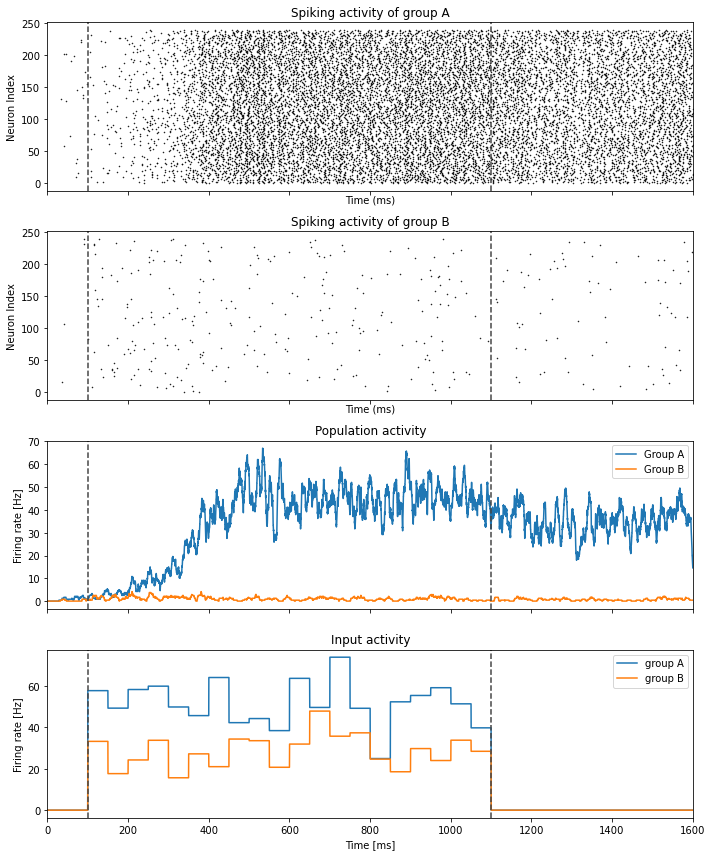

In [16]:
fig, gs = plt.subplots(4, 1, figsize=(10, 12), sharex='all')
t_start = 0.

# the raster plot of A
fig.add_subplot(gs[0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")

# the raster plot of A
fig.add_subplot(gs[1])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")

# the firing rate of A and B
fig.add_subplot(gs[2])
rateA = bp.measure.firing_rate(runner.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(runner.mon['B.spike'], width=10.)
plt.plot(runner.mon.ts, rateA, label="Group A")
plt.plot(runner.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.legend()

# the external stimuli
fig.add_subplot(gs[3])
plt.plot(runner.mon.ts, runner.mon['IA.freq'], label="group A")
plt.plot(runner.mon.ts, runner.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.legend()

for i in range(4):
  gs[i].axvline(pre_stimulus_period, linestyle='dashed', color=u'#444444')
  gs[i].axvline(pre_stimulus_period + stimulus_period, linestyle='dashed', color=u'#444444')

plt.xlim(t_start, total_period + 1)
plt.xlabel("Time [ms]")
plt.tight_layout()
plt.show()

For more information about brain dynamic simulation, please refer to [Dynamics Simulation](../tutorial_simulation/index.rst) in the BDP tutorial.

## References

1. van Vreeswijk, C., & Sompolinsky, H. (1996). Chaos in neuronal networks with balanced excitatory and inhibitory activity. Science (New York, N.Y.), 274(5293), 1724–1726. https://doi.org/10.1126/science.274.5293.1724

2. Wang X. J. (2002). Probabilistic decision making by slow reverberation in cortical circuits. Neuron, 36(5), 955–968. https://doi.org/10.1016/s0896-6273(02)01092-9